## Proyecto Final Métodos Analíticos
### Francisco Bahena, Cristian Challu, Daniel Sharp

Carga de librerías

In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import sys
import time
from IPython.display import clear_output
from io import StringIO

Carga de los datos y presentación:

In [2]:
import requests
import pandas as pd

flujo = pd.read_csv('flujo_malls.csv')
flujo = flujo.iloc[:,1:]

Nuestros datos consisten de un log de conexiones a nodos de 3 centros comerciales. Entre los 3 centros tenemos 32 nodos 'wifi' a los que intentan conectarse dispositivos de los individuos que transitan cerca o dentro de los centros comerciales. En los datos contamos con 4 columnas, son:  
- MAC address del Nodo de Wifi
- MAC address del dispositivo
- Potencia de la conexión
- Timestamp de la conexión

In [3]:
flujo.head()

,nodo,mac_x,pot,fecha,name
0,e4956e43855b,90:97:f3:60:0a:0c,-77,2018-04-16 02:59:36,Hera Mall
1,e4956e43855b,c8:3a:35:c1:2a:4c,-72,2018-04-16 03:00:03,Hera Mall
2,e4956e43855b,c8:3a:35:c1:2a:4c,-63,2018-04-16 03:02:09,Hera Mall
3,e4956e43855b,c8:3a:35:c1:2b:c3,-82,2018-04-16 03:04:28,Hera Mall
4,e4956e43855b,c8:3a:35:c1:2a:4c,-76,2018-04-16 03:05:44,Hera Mall


In [4]:
flujo['fecha'] = pd.to_datetime(flujo['fecha'], format = '%Y-%m-%d %H:%M:%S')
flujo['day'] = flujo['fecha'].apply(lambda x: x.day)
flujo['hour'] = flujo['fecha'].apply(lambda x: x.hour)
flujo['minute'] = flujo['fecha'].apply(lambda x: x.minute)

Limpiamos nuestros datos y creamos variables para día, hora y minuto de tal forma que sea más sencillo filtrar y trabajar con los datos.

In [23]:
flujo_f = flujo.loc[(flujo['day'] == 17 ) & (flujo['hour'] == 8) & (flujo['pot'] >= -70)]

In [24]:
flujo_f.shape

(26957, 8)

### Ejecución del Bloom filter para dispositivos unicos
Para la ejecución del bloom se 'levantó' un API en un servidor con nuestra implementación del Bloom Filter. Para simular el stream de nuestros datos, enviamos las observaciones al API en bloques de un minuto y obtenemos el número de 'nuevos' dispositivos contados por el Filtro de Bloom al igual que el número de dispositivos que ya existían. Hacemos lo mismo con una base de datos para obtener los valores reales. Se reporta el error teórico esperado y el error real. También obtenemos el tiempo de ejecución tanto para nuestro Filtro de Bloom como de la base de datos.
 

Con el siguiente comando reestablecemos la base y el Filtro de Bloom. Además, enviamos parámetros para la construcción del Filtro, como en número de hashes y el tamaño del vector filtro.

In [40]:
n = 81203
k = 10

In [41]:
requests.get('http://54.157.13.52:3000/limpia_db_bloom/'+str(k)+'/'+str(n))

<Response [200]>

A continuación 'simulamos' el stream de datos, enviando las observaciones en bloques de un minuto por un tiempo total de 10 horas.

{'visitas_existentes': 250, 'tiempo_en_segundos': '0.019130468368530273', 'nuevas_visitas': 7}
{'visitas_existentes_base': 241, 'tiempo_en_segundos': '0.39720630645751953', 'nuevas_visitas_base': 16}


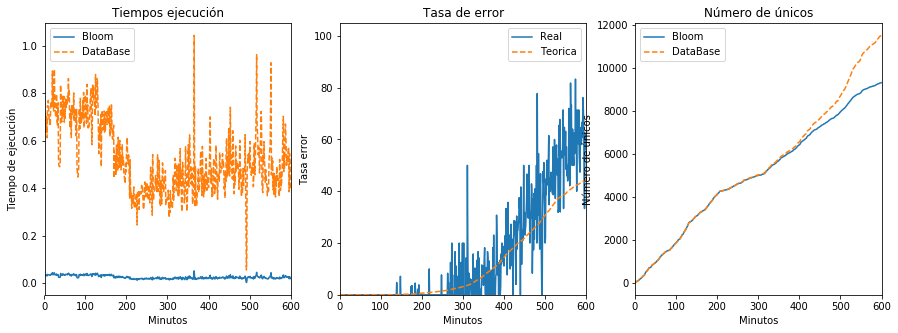

In [42]:
# Hora de inicio y fin de simulacion
hora = 8
hora_fin = 18

# Vector numpy con estadisticas
history = np.empty((0,7),float)
num_unicos_bloom = 0
num_unicos_db = 0
plt.close()

while hora < hora_fin:
    # Contador de minuto
    contador = -1
    # Hora actual
    hora = hora+1
    # Se filtra la base para obtener solo la hora considerada
    flujo_f = flujo.loc[(flujo['day'] == 17 )& (flujo['hour'] == hora) & (flujo['pot'] >= -70)] 
    
    # Iteramos en cada minuto de cada hora
    for minuto in range(60):
        # Contador con minuto considerado
        contador += 1
        print("Hora: {} Minuto: {}".format(hora-1, minuto))
        
        # Se filtra la base para obtener solo el minuto considerado
        base = flujo_f.loc[flujo_f['minute'] == minuto]
        base = base[['mac_x']].values.tolist()
        elementos = ['-'.join(elemento) for elemento in base]
        
        # Request al API para numero total de elementos en filtro
        r = requests.get('http://54.157.13.52:3000/check_bloom_db/')
        num_unicos_total = r.json()['elementos_insertados_en_bloom']
        
        # Tasa de error teorica
        tasa_teorica = 100*(1-(1-1/n)**(num_unicos_total*k))**k
        
        # Llamamos al API y enviamos los elementos del minuto actual al Bloom Filter
        r_bloom = requests.post('http://54.157.13.52:3000/insert_elements_bloom/', json= {'records':elementos})
        elapsed_bloom = float(r_bloom.json()['tiempo_en_segundos'])
        # Llamamos al API y enviamos los elementos del minuto actual a la Base de Datos
        r_db = requests.post('http://54.157.13.52:3000/insert_elements_db/', json= {'records':elementos})
        elapsed_db = float(r_db.json()['tiempo_en_segundos'])
        
        # Tasa de error real
        if r_db.json()['nuevas_visitas_base'] > 0:
            tasa_error = 100*(1- r_bloom.json()['nuevas_visitas']/r_db.json()['nuevas_visitas_base'])
        else:
            tasa_error = 0
        
        # Numero de elementos unicos de este flujo
        num_unicos_bloom += r_bloom.json()['nuevas_visitas']
        num_unicos_db += r_db.json()['nuevas_visitas_base']
        
        # Se guardan estadisticas en historia
        step = [contador, elapsed_bloom, elapsed_db, tasa_error, tasa_teorica, num_unicos_bloom, num_unicos_db]
        history = np.vstack((history, step))
        
        # Graficamos nuestros resultados para las diferentes métricas consideradas
        clear_output()
        print(r_bloom.json())
        print(r_db.json())
        plt.figure(1)
        plt.figure(figsize = (15, 5))
        plt.subplot(131)
        plt.plot(history[:,1], label = "Bloom", linestyle = '-')
        plt.plot(history[:,2], label = "DataBase", linestyle = '--')
        plt.legend()
        plt.xlabel("Minutos")
        plt.ylabel("Tiempo de ejecución")
        plt.title("Tiempos ejecución")
        plt.xlim((1,600))
        plt.subplot(132)
        plt.plot(history[:,3], linestyle = '-', label = "Real")
        plt.plot(history[:,4], linestyle = '--', label = "Teorica")
        plt.ylim((0, 105))
        plt.legend()
        plt.ylabel("Tasa error")
        plt.xlabel("Minutos")
        plt.title("Tasa de error")
        plt.xlim((1,600))
        plt.subplot(133)
        plt.plot(history[:,5], label = "Bloom", linestyle = '-')
        plt.plot(history[:,6], label = "DataBase", linestyle = '--')
        plt.legend()
        plt.ylabel("Número de únicos")
        plt.xlabel("Minutos")
        plt.title("Número de únicos")
        plt.xlim((1,600))
        plt.show()

El Bloom Filter nos permite ver el número de individuos únicos en cierto periodo de tiempo al igual que detectar, en un periodo de un minuto de tiempo, cuantos de los dispositivos son nuevos y cuantos ya habían aparecido en alguno de los 3 centros comerciales.

### Ejecución del Bloom filter para filtrar empleados
Para esta implementación del Bloom filter primero añadimos un subconjunto de MAC address distintas al filtro, que simulan los dispositivos de los empleados de las tiendas del centro comercial. Obtenemos el número de dispositivos filtrados y no filtrados por el Filtro de Bloom. Hacemos lo mismo con una base de datos para obtener los valores reales. Se reporta el error teórico esperado y el error real. También obtenemos el tiempo de ejecución tanto para nuestro Filtro de Bloom como de la base de datos.

Primero se crea una base de direcciones que representan a los empleados del centro comercial. Luego se agregan los registros al bloom filter.

In [43]:
empleados = flujo.sample(frac=0.1, replace=False)
base = empleados[['mac_x']].values.tolist()
elementos = ['-'.join(elemento) for elemento in base]

In [44]:
n = 16253
k = 10

In [45]:
requests.get('http://54.157.13.52:3000/limpia_db_bloom/'+str(k)+'/'+str(n))

<Response [200]>

In [46]:
r_bloom = requests.post('http://54.157.13.52:3000/insert_elements_bloom/', json= {'records':elementos})

In [30]:
# Hora de inicio y fin de simulacion
hora = 5
hora_fin = 10

# Vector numpy con estadisticas
history = np.empty((0,7),float)
num_filtrados_bloom = 0
num_filstrados_db = 0
plt.close()

while hora < hora_fin:
    # Contador de minuto
    contador = -1
    # Hora actual
    hora = hora+1
    # Se filtra la base para obtener solo la hora considerada
    flujo_f = flujo.loc[(flujo['day'] == 18 )& (flujo['hour'] == hora) & (flujo['pot'] >= -70)] 
    
    # Iteramos en cada minuto de cada hora
    for minuto in range(60):
        # Contador con minuto considerado
        contador += 1
        print("Hora: {} Minuto: {}".format(hora-1, minuto))
        
        # Se filtra la base para obtener solo el minuto considerado
        base = flujo_f.loc[flujo_f['minute'] == minuto]
        base = base[['mac_x']].values.tolist()
        elementos = ['-'.join(elemento) for elemento in base]
        
        # Request al API para numero total de elementos en filtro
        r = requests.get('http://54.157.13.52:3000/check_bloom_db/')
        num_unicos_total = r.json()['elementos_insertados_en_bloom']
        
        # Tasa de error teorica
        tasa_teorica = 100*(1-(1-1/n)**(num_unicos_total*k))**k
        
        # Llamamos al API y enviamos los elementos del minuto actual al Bloom Filter
        r_bloom = requests.post('http://54.157.13.52:3000/is_in_filter/', json= {'records':elementos})
        elapsed_bloom = float(r_bloom.json()['tiempo_en_segundos'])
        # Llamamos al API y enviamos los elementos del minuto actual a la Base de Datos
        r_db = requests.post('http://54.157.13.52:3000/is_in_db/', json= {'records':elementos})
        elapsed_db = float(r_db.json()['tiempo_en_segundos'])
        
        # Tasa de error real
        if r_db.json()['nuevas_visitas_base'] > 0:
            tasa_error = 100*(1- r_bloom.json()['nuevas_visitas']/r_db.json()['nuevas_visitas_base'])
        else:
            tasa_error = 0
        
        # Numero de elementos unicos de este flujo
        num_filtrados_bloom += r_bloom.json()['visitas_existentes']
        num_filtrados_db += r_db.json()['visitas_existentes_base']
        
        # Se guardan estadisticas en historia
        step = [contador, elapsed_bloom, elapsed_db, tasa_error, tasa_teorica, num_filtrados_bloom, num_filtrados_db]
        history = np.vstack((history, step))
        
        # Graficamos nuestros resultados para las diferentes métricas consideradas
        clear_output()
        print(r_bloom.json())
        print(r_db.json())
        plt.figure(1)
        plt.figure(figsize = (15, 5))
        plt.subplot(131)
        plt.plot(history[:,1], label = "Bloom", linestyle = '-')
        plt.plot(history[:,2], label = "DataBase", linestyle = '--')
        plt.legend()
        plt.xlabel("Minutos")
        plt.ylabel("Tiempo de ejecución")
        plt.title("Tiempos ejecución")
        plt.xlim((1,600))
        plt.subplot(132)
        plt.plot(history[:,3], linestyle = '-', label = "Real")
        plt.plot(history[:,4], linestyle = '--', label = "Teorica")
        plt.ylim((0, 105))
        plt.legend()
        plt.ylabel("Tasa error")
        plt.xlabel("Minutos")
        plt.title("Tasa de error")
        plt.xlim((1,600))
        plt.subplot(133)
        plt.plot(history[:,5], label = "Bloom", linestyle = '-')
        plt.plot(history[:,6], label = "DataBase", linestyle = '--')
        plt.legend()
        plt.ylabel("Número de únicos")
        plt.xlabel("Minutos")
        plt.title("Número de únicos")
        plt.xlim((1,600))
        plt.show()

### Hyperloglog

In [ ]:
test = flujo.mac.values.tolist()

In [ ]:
requests.get('http://localhost:5000/limpia_hloglog/20')

In [ ]:
r_hll = requests.post('http://localhost:5000/check_unique/', json= {'records':test})

In [ ]:
r_hll.json()